# AI Safety via Debate: MNIST Experiment

In the [original paper](https://arxiv.org/abs/1805.00899) on debate, the authors describe a simple experiment that they performed:

> Metaphorically, debate targets the situation where the agents see the big picture, but the judge cannot. We can model this by replacing the metaphorical big picture with an actual picture, chosen at random from a distribution. If the image is simple enough, we can do away with natural language entirely: the two agents state their claimed image class up front, then reveal one pixel of the image per turn to the judge. They cannot lie about these pixels, but a dishonest player could choose them adversarially to fool the judge. The game ends after a fixed number of turns, then the judge sees a sparse mask of the revealed pixels and decides which agent’s class is correct.

<img src="https://openai.com/content/images/2018/05/debate-game-flow-figure@2x.png"/>

To start with, we will create the weak-classifier judge.

In [238]:
from typing import List, Tuple
import random
from itertools import cycle

import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Data Generation

In [251]:
def normalise(x: np.ndarray) -> np.ndarray:
    x = x - np.min(x)
    x = x / np.max(x)
    return x

class DataGenerator(keras.utils.Sequence):
    '''
        DataGenerator adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    '''
    
    def __init__(self, 
                 data: np.ndarray or List[np.ndarray], 
                 labels: np.ndarray, 
                 batch_size=32, 
                 dim=(28, 28), 
                 n_channels=1,
                 n_classes=10, 
                 shuffle=True, 
                 seed=None):
        'Initialization'
        
        if seed is not None:
            np.random.seed(seed)
        
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        self.labels = to_categorical(labels, 
                                     num_classes=self.n_classes)
        self.data = np.array([
                normalise(sample) 
                for sample in data
        ])
        
        num_samples, *_ = self.data.shape
        self.indices = np.arange(num_samples)
        self.idx_iterator = cycle(range(0, len(self)))
        
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indices after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __len__(self) -> int:
        'Denotes the number of batches per epoch'
        return int(np.floor(self.indices.size / self.batch_size))

    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        'Generate one batch of data'
        # Generate indexes of the batch
        i = index*self.batch_size
        j = (index + 1)*self.batch_size
        indices = self.indices[i:j]

        # Generate data
        X = self.data[indices]
        y = self.labels[indices]

        return X, y
    
    def __next__(self):
        return self[next(self.idx_iterator)]

In [252]:
class MaskedDataGenerator(DataGenerator):
    '''
        DataGenerator that randomly masks generated samples such that only
        a few non-zero elements are preserved.
    '''
    
    def __init__(self,
                 data: np.ndarray or List[np.ndarray], 
                 labels: np.ndarray, 
                 num_preserved=5, 
                 **kwargs):
        super(MaskedDataGenerator, self).__init__(data, labels, **kwargs)
        self.num_preserved = num_preserved
    
    def _create_mask(self, img: np.ndarray) -> np.ndarray:
        non_zero_elements = np.argwhere(img)
        num_non_zero, *_ = non_zero_elements.shape
        sample_indices = np.random.choice(np.arange(num_non_zero), 
                                          size=self.num_preserved)
        sample = non_zero_elements[sample_indices]
        mask = np.zeros(img.shape)
        mask[sample[:, 0], sample[:, 1]] = 1
        return mask
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        X, y = super(MaskedDataGenerator, self).__getitem__(index)
        masks = np.apply_over_axes(lambda x, _: self._create_mask(x), X, 0)
        return X*masks, y

In [4]:
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 7s 1us/step


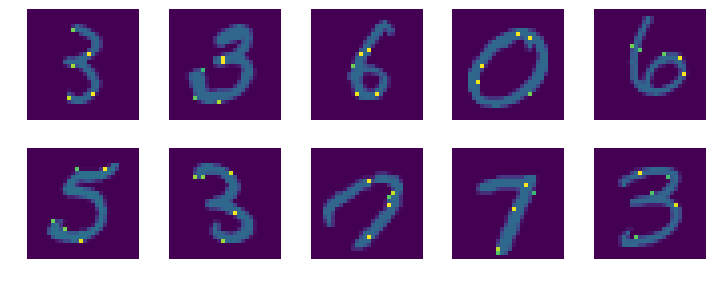

In [255]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
mnist_train_data_gen = DataGenerator(X_train, y_train, seed=0)
masked_mnist_train_data_gen = MaskedDataGenerator(X_train, y_train)
for row in axs:
    for ax in row:
        (img, *_), y = next(mnist_train_data_gen)
        mask = masked_mnist_train_data_gen._create_mask(img)
        ax.imshow(img*0.5 + mask)
        ax.axis('off')
plt.tight_layout()
plt.show()